 Example.jl

 Test program for the functions in ComItAlg.jl, DiscAlg, and SimpRulT.jl.
 The program also uses VAR1SimPs to calculate impulse response functions.

 The program uses a very simplified version of the model in
 Fuhrer, J. C. (1997), "Inflation/Output Variance Trade-Offs and Optimal
 Monetary Policy," JMCB, 29, 214-234.



 This example file and the procedures were created by translating MatLab code
 to Julia.


 Paul Soderlind (Paul.Soderlind@unisg.ch), 20 June 2000, to Julia Jan 2016

In [1]:
using Dates, LinearAlgebra
include("jlFiles/Fuhrer1.jl")
include("jlFiles/VAR1SimPs.jl")
include("jlFiles/SimpRulT.jl")
include("jlFiles/ComitAlg.jl")
include("jlFiles/DiscAlg.jl")
include("jlFiles/printmat.jl")

printwhere (generic function with 1 method)

In [2]:
                               #simplified Fuhrer model, parameter values
(a1,ap,Varey)  = (0.85,-0.41,0.84^2)   #IS equation
(w,gamm,Varep) = (0.65,0.002,0.19^2)   #contracting equation
Dbig = 40                              #arbitrage condition
(qy,qpi,qf,bet) = (1,1,0.5,0.99)       #Loss function

                                #Parameters -> system matrices
(A,B,K,Q,U,R) = Fuhrer1(a1,ap,Varey,w,gamm,Varep,Dbig,qy,qpi,qf,bet)
(n1,n2,K)     = (3,2,1)

T   = 12                          #periods to simulate in VAR
Shock0 = [sqrt(Varep);zeros(2)]   #Impulse response wrt ep

3-element Vector{Float64}:
 0.19
 0.0
 0.0

In [3]:
                         #SIMPLE RULE, u(t)=-Fx(t)
(Fy,Fpi) = (0.5,1.2)     #Simple decision rule: i(t) = = Fy*y(t) + Fpi*[p(t)-p(t-1)]
F   = [0  -Fy  -Fpi*4*(1-w)  0  -Fpi*4*w ]

x10 = zeros(n1)                      #initial state vector
SigmaXX = diagm(0=>[Varep,Varey,0])  #covariance matrix of shocks
(M_Simp,C_Simp,J0) = SimpRulT(A,B,Q,R,U,bet,n1,n2,F,SigmaXX,x10,1.0)

x1 = VAR1SimPs(M_Simp,Shock0,T)        #VAR of x1(t)
x2 = x1*C_Simp'                        #x2(t)
x  = [x1 x2]                           #x(t) = [x1(t),x2(t)]
uu = -x*F'                             #u(t)
ypii_Simp = [x[:,2]  (4*(1-w)*x[:,3]+4*w*x[:,5]) uu]

println("\nSimple rule: impulse response to a one std of price shock (y,pi,i)")
printTable(ypii_Simp,["y","π","i"],string.(1:T),cell00="period")


Simple rule: impulse response to a one std of price shock (y,pi,i)
period         y         π         i
1          0.000     5.694     6.833
2         -0.139     8.254     9.836
3         -0.275     7.487     8.847
4         -0.371     6.747     7.911
5         -0.434     6.043     7.035
6         -0.471     5.383     6.224
7         -0.489     4.769     5.478
8         -0.491     4.203     4.799
9         -0.481     3.687     4.184
10        -0.464     3.219     3.631
11        -0.440     2.798     3.137
12        -0.412     2.420     2.698



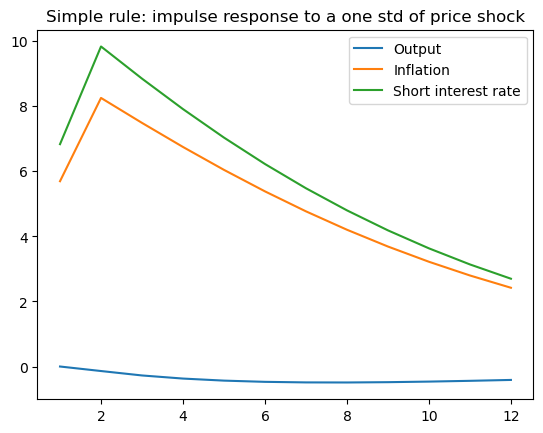

PyObject <matplotlib.legend.Legend object at 0x000002164436EC80>

In [4]:
#plotting, comment out this if PyPlot is not installed
using PyPlot
PyPlot.svg(false)           #prettier if `true`
figure()
  plot(1:T,ypii_Simp)
  title("Simple rule: impulse response to a one std of price shock")
  legend(["Output","Inflation","Short interest rate"])
  #display(gcf())            #uncomment in VsCode

In [5]:
                         #COMMITMENT
(M_Commit,C_Commit) = ComItAlg(A,B,Q,R,U,bet,n1,n2,1.0)

k      = VAR1SimPs(M_Commit,[Shock0;zeros(2)],T) #VAR of x1(t),p2(t)
lambda = k*C_Commit'                             #x2(t),u(t),p1(t)
uu     = lambda[:,n2+1:n2+1]                     #u(t)
x      = [k[:,1:n1] lambda[:,1:n2]]              #x(t) = [x1(t),x2(t)]
ypii_Commit = [x[:,2] (4*(1-w)*x[:,3]+4*w*x[:,5]) uu]

println("\nCommitment: impulse response to a one std of price shock (y,pi,i)")
printTable(ypii_Commit,["y","π","i"],string.(1:T),cell00="period")


Commitment: impulse response to a one std of price shock (y,pi,i)
period         y         π         i
1          0.000     5.404     0.565
2         -0.077     7.514     1.127
3         -0.215     6.294     1.649
4         -0.390     5.095     2.101
5         -0.579     3.937     2.464
6         -0.764     2.836     2.724
7         -0.933     1.812     2.877
8         -1.073     0.880     2.924
9         -1.179     0.056     2.871
10        -1.247    -0.650     2.727
11        -1.274    -1.232     2.505
12        -1.263    -1.687     2.220



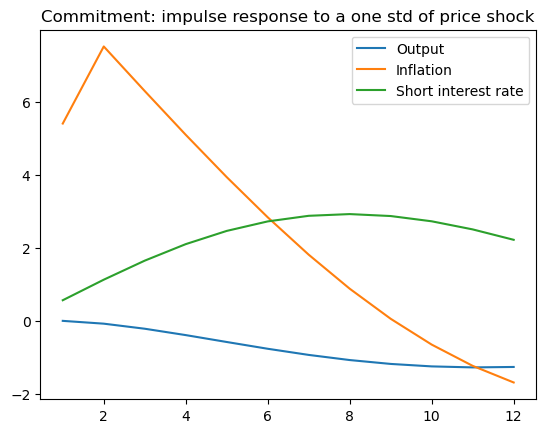

PyObject <matplotlib.legend.Legend object at 0x00000216443B89A0>

In [6]:
#plotting, comment out this if PyPlot is not installed
figure()
  plot(1:T,ypii_Commit)
  title("Commitment: impulse response to a one std of price shock")
  legend(["Output","Inflation","Short interest rate"])
  #display(gcf())            #uncomment in VsCode

In [7]:
                         #DISCRETION
println("\nPlease wait, the discretionary case takes some time to solve")
(M_Disc,C_Disc,V,F) = DiscAlg(A,B,Q,R,U,bet,n1,n2,Matrix(1.0I,n1,n1),zeros(n2,n1),
                               [1e-1;1e-5],0,1,0,1,0,1e+4)

x1 = VAR1SimPs(M_Disc,Shock0,T)        #VAR of x1(t)
x2 = x1*C_Disc'                        #x2(t)
x  = [x1 x2]                           #x(t) = [x1(t),x2(t)]
uu = -x1*F'                            #u(t)
ypii_Disc = [x[:,2] (4*(1-w)*x[:,3]+4*w*x[:,5]) uu]

println("\nDiscretion: impulse response to a one std of price shock (y,pi,i)")
printTable(ypii_Disc,["y","π","i"],string.(1:T),cell00="period")


Please wait, the discretionary case takes some time to solve

Discretion: impulse response to a one std of price shock (y,pi,i)
period         y         π         i
1          0.000     6.058     9.295
2         -0.012     9.173     9.068
3         -0.022     8.949     8.829
4         -0.029     8.727     8.597
5         -0.035     8.508     8.371
6         -0.039     8.292     8.150
7         -0.042     8.080     7.935
8         -0.044     7.872     7.726
9         -0.045     7.669     7.522
10        -0.046     7.470     7.324
11        -0.046     7.275     7.130
12        -0.046     7.085     6.942



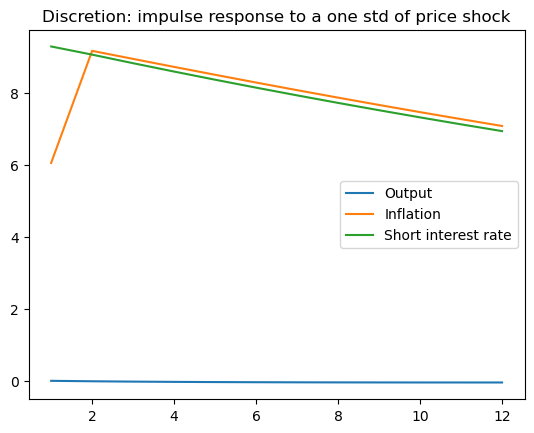

PyObject <matplotlib.legend.Legend object at 0x00000216454A7820>

In [8]:
#plotting, comment out this if PyPlot is not installed
figure()
  plot(1:T,ypii_Disc)
  title("Discretion: impulse response to a one std of price shock")
  legend(["Output","Inflation","Short interest rate"])
  #display(gcf())            #uncomment in VsCode

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*